# The scope of the project is to find the neighborhood in the city of New York and the category most convenient for opening a new activity. 

### 0. Get NY Data

In [1]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

#!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

print('Libraries imported.')

Libraries imported.


In [2]:
with open('newyork_data.json') as json_data:
    newyork_data = json.load(json_data)

In [3]:
neighborhoods_data = newyork_data['features']

In [4]:
# define the dataframe columns
column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 

# instantiate the dataframe
neighborhoods = pd.DataFrame(columns=column_names)

In [5]:
for data in neighborhoods_data:
    borough = neighborhood_name = data['properties']['borough'] 
    neighborhood_name = data['properties']['name']
        
    neighborhood_latlon = data['geometry']['coordinates']
    neighborhood_lat = neighborhood_latlon[1]
    neighborhood_lon = neighborhood_latlon[0]
    
    neighborhoods = neighborhoods.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)

In [6]:
neighborhoods.shape

(306, 4)

In [7]:
print('The dataframe has {} boroughs and {} neighborhoods.'.format(
        len(neighborhoods['Borough'].unique()),
        neighborhoods.shape[0]
    )
)

The dataframe has 5 boroughs and 306 neighborhoods.


Let's take a map of New York City's neighborhoods

In [8]:
address = 'New York City, NY'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of New York City are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of New York City are 40.7308619, -73.9871558.


In [9]:
# create map of New York using latitude and longitude values
map_newyork = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, borough, neighborhood in zip(neighborhoods['Latitude'], neighborhoods['Longitude'], neighborhoods['Borough'], neighborhoods['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_newyork)  
    
map_newyork

### 1. Assumption 1): The best neighboorhood to start a new activity has to be found in neighboorhoods that have the higher number of venues because they are the most crowded location and they are the right places for entrapeneurs

#### 1.1) Let's find the neighborhood with the bigger number of venues

In [10]:
CLIENT_ID = 'F521PNEMUMAVYFYOM122UKJKLWWLYHSSPRFEWX2L2SNRVYWT' # your Foursquare ID
CLIENT_SECRET = '05EIHNXHIOOA0B3DJUBHYJRFBR300RRULIBTAWM4OZMDTTJB' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: F521PNEMUMAVYFYOM122UKJKLWWLYHSSPRFEWX2L2SNRVYWT
CLIENT_SECRET:05EIHNXHIOOA0B3DJUBHYJRFBR300RRULIBTAWM4OZMDTTJB


In [11]:
num_Neigh=len(neighborhoods.Neighborhood)
num_Neigh

306

In [12]:
neighborhoods_data = neighborhoods.reset_index(drop=True)
neighborhoods_data.head()

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


Let's test the first neighborhood

In [13]:
neighborhoods_data.loc[0, 'Neighborhood']

'Wakefield'

In [14]:
neighborhood_latitude = neighborhoods_data.loc[0, 'Latitude'] # neighborhood latitude value
neighborhood_longitude = neighborhoods_data.loc[0, 'Longitude'] # neighborhood longitude value
neighborhood_borough = neighborhoods_data.loc[0, 'Borough'] # neighborhood borough 

neighborhood_name = neighborhoods_data.loc[0, 'Neighborhood'] # neighborhood name

print('Latitude and longitude values of {} are {}, {} and the borough is {}.'.format(neighborhood_name, 
                                                               neighborhood_latitude, 
                                                               neighborhood_longitude,
                                                               neighborhood_borough))

Latitude and longitude values of Wakefield are 40.89470517661, -73.84720052054902 and the borough is Bronx.


Let's create a dataframe with the all the neighborhoods and their number of venues

In [15]:
d = []
for i in range(0,num_Neigh):
    neighborhood_latitude = neighborhoods_data.loc[i, 'Latitude'] # neighborhood latitude value
    neighborhood_longitude = neighborhoods_data.loc[i, 'Longitude'] # neighborhood longitude value
    neighborhood_name = neighborhoods_data.loc[i, 'Neighborhood'] # neighborhood name
    neighborhood_borough = neighborhoods_data.loc[i, 'Borough'] # neighborhood borough 
    

    LIMIT = 5 # limit of number of venues returned by Foursquare API
    radius = 500 # define radius

    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    neighborhood_latitude, 
    neighborhood_longitude, 
    radius, 
    LIMIT)
    
    results = requests.get(url).json()
    venues = results['response']
    #a=venues['headerLocation']
    b=venues['totalResults']

    d.append({'Neighborhood': neighborhood_name, 'N. of venues': b, 'Latitude': neighborhood_latitude, 'Longitude':neighborhood_longitude, 'Borough':neighborhood_borough })
        

df=pd.DataFrame(d)

In [16]:
df.head()

,Borough,Latitude,Longitude,N. of venues,Neighborhood
0,Bronx,40.894705,-73.847201,9,Wakefield
1,Bronx,40.874294,-73.829939,11,Co-op City
2,Bronx,40.887556,-73.827806,21,Eastchester
3,Bronx,40.895437,-73.905643,3,Fieldston
4,Bronx,40.890834,-73.912585,8,Riverdale


Let's copy the Dataframe in order to work on a copy to avoid of redoing the query to FourSquare

In [17]:
df1=df.copy()

In [18]:
df_sorted=df1.sort_values('N. of venues',ascending=False)
df_sorted.head()

,Borough,Latitude,Longitude,N. of venues,Neighborhood
100,Manhattan,40.715618,-73.994279,238,Chinatown
117,Manhattan,40.726933,-73.999914,237,Greenwich Village
121,Manhattan,40.719324,-73.997305,234,Little Italy
248,Manhattan,40.723259,-73.988434,227,Noho
118,Manhattan,40.727847,-73.982226,226,East Village


In [19]:
df_sorted.shape

(306, 5)

Let's consider only the neighborhoods that have at least the 80% of the number of venues respect to the neighborhood with its maximum value

In [20]:
m=max(df_sorted['N. of venues'])

th=m*80/100
df_restricted=df[df['N. of venues']>th]
df_sorted_restr=df_restricted.sort_values('N. of venues',ascending=False)
df_sorted_restr

,Borough,Latitude,Longitude,N. of venues,Neighborhood
100,Manhattan,40.715618,-73.994279,238,Chinatown
117,Manhattan,40.726933,-73.999914,237,Greenwich Village
121,Manhattan,40.719324,-73.997305,234,Little Italy
248,Manhattan,40.723259,-73.988434,227,Noho
118,Manhattan,40.727847,-73.982226,226,East Village
128,Manhattan,40.707107,-74.010665,225,Financial District
250,Manhattan,40.748510,-73.988713,225,Midtown South
114,Manhattan,40.754691,-73.981669,222,Midtown
96,Brooklyn,40.714823,-73.958809,221,North Side
276,Manhattan,40.739673,-73.990947,219,Flatiron


Let's plot the number of venues

In [21]:
import matplotlib.pyplot as plt
%matplotlib inline

,Borough,Latitude,Longitude,N. of venues
Neighborhood,,,,
Chinatown,Manhattan,40.715618,-73.994279,1.000000
Greenwich Village,Manhattan,40.726933,-73.999914,0.978261
Little Italy,Manhattan,40.719324,-73.997305,0.913043
Noho,Manhattan,40.723259,-73.988434,0.760870
East Village,Manhattan,40.727847,-73.982226,0.739130


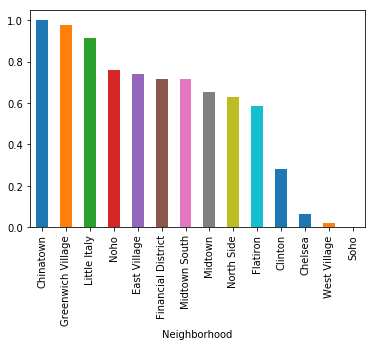

In [22]:
n=min(df_sorted_restr['N. of venues'])
df_sorted_restr_norm=df_sorted_restr.copy()
df_sorted_restr_norm.set_index('Neighborhood',inplace=True)
df_sorted_restr_norm['N. of venues'] = df_sorted_restr_norm['N. of venues'].apply(lambda x: (x - n) / (m - n))
df_sorted_restr_norm['N. of venues'].plot(kind='bar')
df_sorted_restr_norm.head()

In [23]:
address = 'Manhattan, NY'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Manhattan are {}, {}.'.format(latitude, longitude))
# create map of New York using latitude and longitude values

map_crowded = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, borough, neighborhood in zip(df_sorted_restr['Latitude'], df_sorted_restr['Longitude'], df_sorted_restr['Borough'], df_sorted_restr['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_crowded)  
    
map_crowded

The geograpical coordinate of Manhattan are 40.7900869, -73.9598295.


### We have found the neighborhoods that have the bigger number of venues. It means that a lot of people found these neighboorhoods convenient for having an activity.

### 2. Let's find the better category for the activity that can be started in these neighborhoods going to see what could be missing for each neighborhood

Let's cluster the neighborhoods in order to find some hint

In [24]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [25]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    LIMIT = m
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius,
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [26]:
venues = getNearbyVenues(names=df_sorted_restr['Neighborhood'],
                                   latitudes=df_sorted_restr['Latitude'],
                                   longitudes=df_sorted_restr['Longitude']
                                  )

Chinatown
Greenwich Village
Little Italy
Noho
East Village
Financial District
Midtown South
Midtown
North Side
Flatiron
Clinton
Chelsea
West Village
Soho


In [27]:
print(venues.shape)
venues.head()


(1400, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Chinatown,40.715618,-73.994279,SKY TING YOGA,40.716469,-73.995020,Yoga Studio
1,Chinatown,40.715618,-73.994279,Spicy Village 大福星 (Spicy Village),40.717010,-73.993530,Chinese Restaurant
2,Chinatown,40.715618,-73.994279,Mission Escape Games,40.716505,-73.994720,General Entertainment
3,Chinatown,40.715618,-73.994279,Bar Belly,40.715135,-73.991802,Cocktail Bar
4,Chinatown,40.715618,-73.994279,Kiki's,40.714476,-73.992036,Greek Restaurant


In [28]:
venues.to_csv('venues.csv')

#### The dataset contains the top 100 venues for each neighborhood. We use this dataset to extract info on the most common categories

In [29]:
# one hot encoding
venues_onehot = pd.get_dummies(venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
venues_onehot['Neighborhood'] = venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [venues_onehot.columns[-1]] + list(venues_onehot.columns[:-1])
venues_onehot = venues_onehot[fixed_columns]

venues_onehot.head()

,Neighborhood,Accessories Store,Adult Boutique,American Restaurant,Animal Shelter,Antique Shop,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Australian Restaurant,Austrian Restaurant,BBQ Joint,Bagel Shop,Bakery,Bar,Beer Bar,Beer Garden,Beer Store,Bike Rental / Bike Share,Bike Shop,Board Shop,Bookstore,Boutique,Boxing Gym,Brazilian Restaurant,Breakfast Spot,Bubble Tea Shop,Building,Burger Joint,Butcher,Café,Camera Store,Candy Store,Caribbean Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Christmas Market,Clothing Store,Cocktail Bar,Coffee Shop,College Theater,Comedy Club,Concert Hall,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Cycle Studio,Dance Studio,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Dim Sum Restaurant,Diner,Dive Bar,Dog Run,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,English Restaurant,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Fish Market,Flea Market,Flower Shop,Food & Drink Shop,Food Court,Food Truck,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gastropub,Gay Bar,General College & University,General Entertainment,Gift Shop,Gluten-free Restaurant,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,Herbs & Spices Store,Historic Site,History Museum,Hobby Shop,Hot Dog Joint,Hotel,Hotel Bar,Hotpot Restaurant,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Israeli Restaurant,Italian Restaurant,Japanese Curry Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Karaoke Bar,Korean Restaurant,Latin American Restaurant,Lebanese Restaurant,Library,Lingerie Store,Lounge,Malay Restaurant,Market,Martial Arts Dojo,Massage Studio,Mediterranean Restaurant,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Monument / Landmark,Moroccan Restaurant,Movie Theater,Museum,Music School,Music Store,Music Venue,Nail Salon,New American Restaurant,Newsstand,Nightclub,Noodle House,Office,Optical Shop,Organic Grocery,Paella Restaurant,Paper / Office Supplies Store,Park,Performing Arts Venue,Peruvian Restaurant,Pet Café,Pet Store,Pharmacy,Piano Bar,Pie Shop,Pilates Studio,Pizza Place,Playground,Plaza,Poke Place,Portuguese Restaurant,Pub,Ramen Restaurant,Record Shop,Residential Building (Apartment / Condo),Restaurant,Rock Climbing Spot,Rock Club,Roof Deck,Russian Restaurant,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Seafood Restaurant,Shanghai Restaurant,Shoe Store,Skating Rink,Smoke Shop,Snack Place,Soup Place,South American Restaurant,Southern / Soul Food Restaurant,Spa,Spanish Restaurant,Speakeasy,Sporting Goods Shop,Sports Bar,Sports Club,Steakhouse,Street Art,Supermarket,Sushi Restaurant,Swiss Restaurant,Szechuan Restaurant,Taco Place,Tailor Shop,Taiwanese Restaurant,Tapas Restaurant,Tattoo Parlor,Tea Room,Tech Startup,Temple,Thai Restaurant,Theater,Theme Park Ride / Attraction,Thrift / Vintage Store,Tibetan Restaurant,Toy / Game Store,Udon Restaurant,Used Bookstore,Vegetarian / Vegan Restaurant,Venezuelan Restaurant,Vietnamese Restaurant,Watch Shop,Weight Loss Center,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio
0,Chinatown,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1,Chinatown,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0

In [30]:
venues_grouped = venues_onehot.groupby('Neighborhood').mean().reset_index()
venues_grouped

,Neighborhood,Accessories Store,Adult Boutique,American Restaurant,Animal Shelter,Antique Shop,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Australian Restaurant,Austrian Restaurant,BBQ Joint,Bagel Shop,Bakery,Bar,Beer Bar,Beer Garden,Beer Store,Bike Rental / Bike Share,Bike Shop,Board Shop,Bookstore,Boutique,Boxing Gym,Brazilian Restaurant,Breakfast Spot,Bubble Tea Shop,Building,Burger Joint,Butcher,Café,Camera Store,Candy Store,Caribbean Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Christmas Market,Clothing Store,Cocktail Bar,Coffee Shop,College Theater,Comedy Club,Concert Hall,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Cycle Studio,Dance Studio,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Dim Sum Restaurant,Diner,Dive Bar,Dog Run,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,English Restaurant,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Fish Market,Flea Market,Flower Shop,Food & Drink Shop,Food Court,Food Truck,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gastropub,Gay Bar,General College & University,General Entertainment,Gift Shop,Gluten-free Restaurant,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,Herbs & Spices Store,Historic Site,History Museum,Hobby Shop,Hot Dog Joint,Hotel,Hotel Bar,Hotpot Restaurant,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Israeli Restaurant,Italian Restaurant,Japanese Curry Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Karaoke Bar,Korean Restaurant,Latin American Restaurant,Lebanese Restaurant,Library,Lingerie Store,Lounge,Malay Restaurant,Market,Martial Arts Dojo,Massage Studio,Mediterranean Restaurant,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Monument / Landmark,Moroccan Restaurant,Movie Theater,Museum,Music School,Music Store,Music Venue,Nail Salon,New American Restaurant,Newsstand,Nightclub,Noodle House,Office,Optical Shop,Organic Grocery,Paella Restaurant,Paper / Office Supplies Store,Park,Performing Arts Venue,Peruvian Restaurant,Pet Café,Pet Store,Pharmacy,Piano Bar,Pie Shop,Pilates Studio,Pizza Place,Playground,Plaza,Poke Place,Portuguese Restaurant,Pub,Ramen Restaurant,Record Shop,Residential Building (Apartment / Condo),Restaurant,Rock Climbing Spot,Rock Club,Roof Deck,Russian Restaurant,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Seafood Restaurant,Shanghai Restaurant,Shoe Store,Skating Rink,Smoke Shop,Snack Place,Soup Place,South American Restaurant,Southern / Soul Food Restaurant,Spa,Spanish Restaurant,Speakeasy,Sporting Goods Shop,Sports Bar,Sports Club,Steakhouse,Street Art,Supermarket,Sushi Restaurant,Swiss Restaurant,Szechuan Restaurant,Taco Place,Tailor Shop,Taiwanese Restaurant,Tapas Restaurant,Tattoo Parlor,Tea Room,Tech Startup,Temple,Thai Restaurant,Theater,Theme Park Ride / Attraction,Thrift / Vintage Store,Tibetan Restaurant,Toy / Game Store,Udon Restaurant,Used Bookstore,Vegetarian / Vegan Restaurant,Venezuelan Restaurant,Vietnamese Restaurant,Watch Shop,Weight Loss Center,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio
0,Chelsea,0.00,0.00,0.04,0.00,0.01,0.00,0.00,0.03,0.00,0.00,0.02,0.00,0.00,0.00,0.00,0.04,0.01,0.01,0.00,0.00,0.00,0.00,0.00,0.02,0.00,0.00,0.00,0.01,0.00,0.00,0.01,0.01,0.01,0.00,0.00,0.00,0.01,0.00,0.00,0.00,0.00,0.01,0.07,0.01,0.00,0.00,0.00,0.01,0.01,0.00,0.02,0.01,0.00,0.00,0.00,0.00,0.01,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.01,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.01,0.00,0.00,0.00,0.00,0.00,0.01,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.02,0.00,0.00,0.00,0.00,0.01,0.01,0.01,0.00,0.00,0.02,0.00,0.00,0.00,0.00,0.00,0.00,0.03,0.00,0.00,0.05,0.01,0.

In [31]:
num_top_venues = 30

for hood in venues_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = venues_grouped[venues_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Chelsea----
                      venue  freq
0               Coffee Shop  0.07
1        Italian Restaurant  0.06
2            Ice Cream Shop  0.05
3                    Bakery  0.04
4       American Restaurant  0.04
5                 Nightclub  0.04
6               Art Gallery  0.03
7        Seafood Restaurant  0.03
8                   Theater  0.03
9                     Hotel  0.03
10             Cupcake Shop  0.02
11         Tapas Restaurant  0.02
12                Gift Shop  0.02
13  Health & Beauty Service  0.02
14                Bookstore  0.02
15                   Market  0.02
16         Asian Restaurant  0.02
17        Indian Restaurant  0.01
18           Sandwich Place  0.01
19                 Creperie  0.01
20              Music Venue  0.01
21             Cycle Studio  0.01
22               Steakhouse  0.01
23             Dessert Shop  0.01
24                Speakeasy  0.01
25  New American Restaurant  0.01
26        Electronics Store  0.01
27       Mexican Restaurant  0.0

                    venue  freq
0      Italian Restaurant  0.08
1       French Restaurant  0.05
2             Coffee Shop  0.04
3            Cocktail Bar  0.04
4        Sushi Restaurant  0.03
5     American Restaurant  0.03
6               Gift Shop  0.03
7           Grocery Store  0.03
8                   Hotel  0.03
9      Mexican Restaurant  0.03
10              Bookstore  0.03
11            Pizza Place  0.02
12          Deli / Bodega  0.02
13               Boutique  0.02
14         Sandwich Place  0.02
15              Rock Club  0.02
16              Wine Shop  0.02
17               Wine Bar  0.02
18            Art Gallery  0.02
19             Street Art  0.01
20             Whisky Bar  0.01
21         Ice Cream Shop  0.01
22              Hotel Bar  0.01
23  Venezuelan Restaurant  0.01
24   Herbs & Spices Store  0.01
25   Gym / Fitness Center  0.01
26                    Gym  0.01
27             Steakhouse  0.01
28       Greek Restaurant  0.01
29           Gourmet Shop  0.01


----No

In [32]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [33]:
num_top_venues = 30

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = venues_grouped['Neighborhood']

for ind in np.arange(venues_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(venues_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,11th Most Common Venue,12th Most Common Venue,13th Most Common Venue,14th Most Common Venue,15th Most Common Venue,16th Most Common Venue,17th Most Common Venue,18th Most Common Venue,19th Most Common Venue,20th Most Common Venue,21th Most Common Venue,22th Most Common Venue,23th Most Common Venue,24th Most Common Venue,25th Most Common Venue,26th Most Common Venue,27th Most Common Venue,28th Most Common Venue,29th Most Common Venue,30th Most Common Venue
0,Chelsea,Coffee Shop,Italian Restaurant,Ice Cream Shop,American Restaurant,Nightclub,Bakery,Theater,Hotel,Art Gallery,Seafood Restaurant,Gift Shop,Market,Cupcake Shop,Bookstore,Tapas Restaurant,Health & Beauty Service,Asian Restaurant,Israeli Restaurant,Paella Restaurant,Café,Antique Shop,Women's Store,Cycle Studio,Cheese Shop,Japanese Restaurant,Fish Market,Scenic Lookout,Sandwich Place,Mexican Restaurant,Burger Joint
1,Chinatown,Chinese Restaurant,Bubble Tea Shop,Dim Sum Restaurant,Vietnamese Restaurant,American Restaurant,Cocktail Bar,Hotpot Restaurant,Noodle House,Salon / Barbershop,Bakery,Malay Restaurant,Spa,Bar,Coffee Shop,Ice Cream Shop,Dumpling Restaurant,Asian Restaurant,Optical Shop,Sandwich Place,Mexican Restaurant,Museum,Music Venue,Nail Salon,Record Shop,New American Restaurant,Restaurant,Paper / Office Supplies Store,Pharmacy,Men's Store,Pizza Place
2,Clinton,Theater,Coffee Shop,Italian Restaurant,Gym / Fitness Center,American Restaurant,Hotel,Spa,Gym,Wine Shop,Seafood Restaurant,Sandwich Place,Lounge,Wine Bar,Indie Theater,French Restaurant,Dog Run,New American Restaurant,Movie Theater,Deli / Bodega,Café,Food Court,Chinese Restaurant,Roof Deck,Cocktail Bar,Rock Climbing Spot,Restaurant,Residential Building (Apartment / Condo),Dive Bar,Diner,Market
3,East Village,Ice Cream Shop,Bar,Wine Bar,Mexican Restaurant,Cocktail Bar,Speakeasy,Chinese Restaurant,Ramen Restaurant,Pizza Place,Bagel Shop,Korean Restaurant,Japanese Restaurant,Café,Seafood Restaurant,Coffee Shop,Filipino Restaurant,Italian Restaurant,Vegetarian / Vegan Restaurant,Wine Shop,American Restaurant,Vietnamese Restaurant,Arepa Restaurant,Cupcake Shop,Dumpling Restaurant,Dog Run,Event Space,Caribbean Restaurant,Cheese Shop,Middle Eastern Restaurant,Record Shop
4,Financial District,Coffee Shop,Hotel,Bar,Gym,Wine Shop,Steakhouse,Italian Restaurant,Food Truck,Pizza Place,Falafel Restaurant,Juice Bar,Jewelry Store,Japanese Restaurant,Monument / Landmark,Park,Sandwich Place,Spa,Gym / Fitness Center,Vegetarian / Vegan Restaurant,Event Space,American Restaurant,Café,Bakery,Burger Joint,Lingerie Store,Market,Mediterranean Restaurant,Mexican Restaurant,New American Restaurant,Museum
5,Flatiron,Italian Restaurant,New American Restaurant,American Restaurant,Gym / Fitness Center,Yoga Studio,Cosmetics Shop,Bakery,Women's Store,Japanese Restaurant,Dessert Shop,Cycle Studio,Clothing Store,Salon / Barbershop,Sporting Goods Shop,Gym,Vegetarian / Vegan Restaurant,Furniture / Home Store,Bookstore,Spa,Coffee Shop,Wine Shop,Mexican Restaurant,Juice Bar,Burger Joint,Israeli Restaurant,Gift Shop,Salad Place,Camera Store,Russian Restaurant,Cheese Shop
6,Greenwich Village,Italian Restaurant,Clothing Store,Sushi Restaurant,French Restaurant,Seafood Restaurant,Indian Restaurant,Café,Chinese Restaurant,Electronics Store,Sandwich Place,Ice Cream Shop,Gourmet Shop,Cocktail Bar,Cosmetics Shop,Coffee Shop,Caribbean Restaurant,Burger Joint,Boutique,Bakery,American Restaurant,Spa,Yoga Studio,Vietnamese Restaurant,Cuban Restaurant,Optical Shop,Indie Movie Theater,Bookstore,Wine Bar,Salon / Barbershop,Eastern European Restaurant
7,Little Italy,Bakery,Café,Yoga Studio,Cocktail Bar,Salon / Barbershop,Ice Cream Shop,Seafood Restaurant,Sandwich Place,Bubble Tea Shop,Clothing Store,Chinese Restaurant,French Res

In [34]:
# set number of clusters
kclusters = 3

venues_grouped_clustering = venues_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(venues_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([1, 0, 1, 0, 1, 0, 0, 0, 1, 2], dtype=int32)

In [35]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

venues_merged =df_sorted_restr

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
venues_merged = venues_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

venues_merged.head() # check the last columns!

,Borough,Latitude,Longitude,N. of venues,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,11th Most Common Venue,12th Most Common Venue,13th Most Common Venue,14th Most Common Venue,15th Most Common Venue,16th Most Common Venue,17th Most Common Venue,18th Most Common Venue,19th Most Common Venue,20th Most Common Venue,21th Most Common Venue,22th Most Common Venue,23th Most Common Venue,24th Most Common Venue,25th Most Common Venue,26th Most Common Venue,27th Most Common Venue,28th Most Common Venue,29th Most Common Venue,30th Most Common Venue
100,Manhattan,40.715618,-73.994279,238,Chinatown,0,Chinese Restaurant,Bubble Tea Shop,Dim Sum Restaurant,Vietnamese Restaurant,American Restaurant,Cocktail Bar,Hotpot Restaurant,Noodle House,Salon / Barbershop,Bakery,Malay Restaurant,Spa,Bar,Coffee Shop,Ice Cream Shop,Dumpling Restaurant,Asian Restaurant,Optical Shop,Sandwich Place,Mexican Restaurant,Museum,Music Venue,Nail Salon,Record Shop,New American Restaurant,Restaurant,Paper / Office Supplies Store,Pharmacy,Men's Store,Pizza Place
117,Manhattan,40.726933,-73.999914,237,Greenwich Village,0,Italian Restaurant,Clothing Store,Sushi Restaurant,French Restaurant,Seafood Restaurant,Indian Restaurant,Café,Chinese Restaurant,Electronics Store,Sandwich Place,Ice Cream Shop,Gourmet Shop,Cocktail Bar,Cosmetics Shop,Coffee Shop,Caribbean Restaurant,Burger Joint,Boutique,Bakery,American Restaurant,Spa,Yoga Studio,Vietnamese Restaurant,Cuban Restaurant,Optical Shop,Indie Movie Theater,Bookstore,Wine Bar,Salon / Barbershop,Eastern European Restaurant
121,Manhattan,40.719324,-73.997305,234,Little Italy,0,Bakery,Café,Yoga Studio,Cocktail Bar,Salon / Barbershop,Ice Cream Shop,Seafood Restaurant,Sandwich Place,Bubble Tea Shop,Clothing Store,Chinese Restaurant,French Restaurant,Women's Store,Japanese Restaurant,Massage Studio,Mediterranean Restaurant,Pizza Place,Boutique,Cosmetics Shop,Italian Restaurant,Thai Restaurant,Wine Bar,Middle Eastern Restaurant,Rock Club,Vietnamese Restaurant,Hotel,Newsstand,Martial Arts Dojo,Salad Place,Vegetarian / Vegan Restaurant
248,Manhattan,40.723259,-73.988434,227,Noho,0,Italian Restaurant,French Restaurant,Cocktail Bar,Coffee Shop,Mexican Restaurant,American Restaurant,Hotel,Sushi Restaurant,Grocery Store,Gift Shop,Bookstore,Rock Club,Pizza Place,Deli / Bodega,Sandwich Place,Boutique,Wine Shop,Wine Bar,Art Gallery,Candy Store,Herbs & Spices Store,Sake Bar,Adult Boutique,Pilates Studio,New American Restaurant,Music Venue,Japanese Restaurant,Indie Movie Theater,Indian Restaurant,Ice Cream Shop
118,Manhattan,40.727847,-73.982226,226,East Village,0,Ice Cream Shop,Bar,Wine Bar,Mexican Restaurant,Cocktail Bar,Speakeasy,Chinese Restaurant,Ramen Restaurant,Pizza Place,Bagel Shop,Korean Restaurant,Japanese Restaurant,Café,Seafood Restaurant,Coffee Shop,Filipino Restaurant,Italian Restaurant,Vegetarian / Vegan Restaurant,Wine Shop,American Restaurant,Vietnamese Restaurant,Arepa Restaurant,Cupcake Shop,Dumpling Restaurant,Dog Run,Event Space,Caribbean Restaurant,Cheese Shop,Middle Eastern Restaurant,Record Shop


In [36]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(venues_merged['Latitude'], venues_merged['Longitude'], venues_merged['Neighborhood'], venues_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

In [37]:
# repeat the same analysis with 5 cluster
# set number of clusters
kclusters = 5

venues_grouped_clustering = venues_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(venues_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([2, 1, 2, 1, 2, 1, 0, 1, 2, 3], dtype=int32)

In [38]:
# add clustering labels
#neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)
neighborhoods_venues_sorted['Cluster Labels']=kmeans.labels_
venues_merged =df_sorted_restr

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
venues_merged = venues_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

venues_merged # check the last columns!

,Borough,Latitude,Longitude,N. of venues,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,11th Most Common Venue,12th Most Common Venue,13th Most Common Venue,14th Most Common Venue,15th Most Common Venue,16th Most Common Venue,17th Most Common Venue,18th Most Common Venue,19th Most Common Venue,20th Most Common Venue,21th Most Common Venue,22th Most Common Venue,23th Most Common Venue,24th Most Common Venue,25th Most Common Venue,26th Most Common Venue,27th Most Common Venue,28th Most Common Venue,29th Most Common Venue,30th Most Common Venue
100,Manhattan,40.715618,-73.994279,238,Chinatown,1,Chinese Restaurant,Bubble Tea Shop,Dim Sum Restaurant,Vietnamese Restaurant,American Restaurant,Cocktail Bar,Hotpot Restaurant,Noodle House,Salon / Barbershop,Bakery,Malay Restaurant,Spa,Bar,Coffee Shop,Ice Cream Shop,Dumpling Restaurant,Asian Restaurant,Optical Shop,Sandwich Place,Mexican Restaurant,Museum,Music Venue,Nail Salon,Record Shop,New American Restaurant,Restaurant,Paper / Office Supplies Store,Pharmacy,Men's Store,Pizza Place
117,Manhattan,40.726933,-73.999914,237,Greenwich Village,0,Italian Restaurant,Clothing Store,Sushi Restaurant,French Restaurant,Seafood Restaurant,Indian Restaurant,Café,Chinese Restaurant,Electronics Store,Sandwich Place,Ice Cream Shop,Gourmet Shop,Cocktail Bar,Cosmetics Shop,Coffee Shop,Caribbean Restaurant,Burger Joint,Boutique,Bakery,American Restaurant,Spa,Yoga Studio,Vietnamese Restaurant,Cuban Restaurant,Optical Shop,Indie Movie Theater,Bookstore,Wine Bar,Salon / Barbershop,Eastern European Restaurant
121,Manhattan,40.719324,-73.997305,234,Little Italy,1,Bakery,Café,Yoga Studio,Cocktail Bar,Salon / Barbershop,Ice Cream Shop,Seafood Restaurant,Sandwich Place,Bubble Tea Shop,Clothing Store,Chinese Restaurant,French Restaurant,Women's Store,Japanese Restaurant,Massage Studio,Mediterranean Restaurant,Pizza Place,Boutique,Cosmetics Shop,Italian Restaurant,Thai Restaurant,Wine Bar,Middle Eastern Restaurant,Rock Club,Vietnamese Restaurant,Hotel,Newsstand,Martial Arts Dojo,Salad Place,Vegetarian / Vegan Restaurant
248,Manhattan,40.723259,-73.988434,227,Noho,0,Italian Restaurant,French Restaurant,Cocktail Bar,Coffee Shop,Mexican Restaurant,American Restaurant,Hotel,Sushi Restaurant,Grocery Store,Gift Shop,Bookstore,Rock Club,Pizza Place,Deli / Bodega,Sandwich Place,Boutique,Wine Shop,Wine Bar,Art Gallery,Candy Store,Herbs & Spices Store,Sake Bar,Adult Boutique,Pilates Studio,New American Restaurant,Music Venue,Japanese Restaurant,Indie Movie Theater,Indian Restaurant,Ice Cream Shop
118,Manhattan,40.727847,-73.982226,226,East Village,1,Ice Cream Shop,Bar,Wine Bar,Mexican Restaurant,Cocktail Bar,Speakeasy,Chinese Restaurant,Ramen Restaurant,Pizza Place,Bagel Shop,Korean Restaurant,Japanese Restaurant,Café,Seafood Restaurant,Coffee Shop,Filipino Restaurant,Italian Restaurant,Vegetarian / Vegan Restaurant,Wine Shop,American Restaurant,Vietnamese Restaurant,Arepa Restaurant,Cupcake Shop,Dumpling Restaurant,Dog Run,Event Space,Caribbean Restaurant,Cheese Shop,Middle Eastern Restaurant,Record Shop
128,Manhattan,40.707107,-74.010665,225,Financial District,2,Coffee Shop,Hotel,Bar,Gym,Wine Shop,Steakhouse,Italian Restaurant,Food Truck,Pizza Place,Falafel Restaurant,Juice Bar,Jewelry Store,Japanese Restaurant,Monument / Landmark,Park,Sandwich Place,Spa,Gym / Fitness Center,Vegetarian / Vegan Restaurant,Event Space,American Restaurant,Café,Bakery,Burger Joint,Lingerie Store,Market,Mediterranean Restaurant,Mexican Restaurant,New American Restaurant,Museum
250,Manhattan,40.748510,-73.988713,225,Midtown South,3,Korean Restaurant,Coffee Shop,Cosmetics Shop,Japanese Restaurant,Hotel Bar,Hotel,Italian Restaurant,Gym / Fitness Center,Bakery,Boutique,Cocktail Bar,Lingerie Store,Food Court,Gastropub,Food Truck,Scenic Lookout,Desse

In [39]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(venues_merged['Latitude'], venues_merged['Longitude'], venues_merged['Neighborhood'], venues_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

### HINT: IN BOTH CASES (NUMBER OF CLUSTER UGUAL TO 3 AND 5) THE MIDTOWN SOUTH NEIGHBORHOOD IS A UNIQUE CLUSTER.

### ASSUMPTION 2) THE CATEGORY OF THE NEW ACTIVITY HAS TO SEARCHED INTO THE MOST COMMON ACTIVITIES IN THE MIDTOWN SOUTH NEIGHBORHOOD

### ASSUMPTION 3) BECAUSE LITTLE ITALY IS BETWEEN TWO MAIN NEIGHBORHOODS (CHINA TOWN AND SOHO) AND EACH NEIGHBORHOOD IS VERY CLOSE TO EACH OTHER (1 km FROM CHINA TOWN TO SOHO), LITTLE ITALY CAN BE CONSIDERED THE RIGHT PLACE FOR A NEW ACTIVITY

Let's see which venues' category in Midtown South is not common in the China Town-Little Italy-Soho area:

In [40]:
chinatown=venues_merged.loc[venues_merged['Neighborhood']=='Chinatown']
chinatown

,Borough,Latitude,Longitude,N. of venues,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,11th Most Common Venue,12th Most Common Venue,13th Most Common Venue,14th Most Common Venue,15th Most Common Venue,16th Most Common Venue,17th Most Common Venue,18th Most Common Venue,19th Most Common Venue,20th Most Common Venue,21th Most Common Venue,22th Most Common Venue,23th Most Common Venue,24th Most Common Venue,25th Most Common Venue,26th Most Common Venue,27th Most Common Venue,28th Most Common Venue,29th Most Common Venue,30th Most Common Venue
100,Manhattan,40.715618,-73.994279,238,Chinatown,1,Chinese Restaurant,Bubble Tea Shop,Dim Sum Restaurant,Vietnamese Restaurant,American Restaurant,Cocktail Bar,Hotpot Restaurant,Noodle House,Salon / Barbershop,Bakery,Malay Restaurant,Spa,Bar,Coffee Shop,Ice Cream Shop,Dumpling Restaurant,Asian Restaurant,Optical Shop,Sandwich Place,Mexican Restaurant,Museum,Music Venue,Nail Salon,Record Shop,New American Restaurant,Restaurant,Paper / Office Supplies Store,Pharmacy,Men's Store,Pizza Place


In [41]:
littleitaly=venues_merged.loc[venues_merged['Neighborhood']=='Little Italy']
littleitaly

,Borough,Latitude,Longitude,N. of venues,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,11th Most Common Venue,12th Most Common Venue,13th Most Common Venue,14th Most Common Venue,15th Most Common Venue,16th Most Common Venue,17th Most Common Venue,18th Most Common Venue,19th Most Common Venue,20th Most Common Venue,21th Most Common Venue,22th Most Common Venue,23th Most Common Venue,24th Most Common Venue,25th Most Common Venue,26th Most Common Venue,27th Most Common Venue,28th Most Common Venue,29th Most Common Venue,30th Most Common Venue
121,Manhattan,40.719324,-73.997305,234,Little Italy,1,Bakery,Café,Yoga Studio,Cocktail Bar,Salon / Barbershop,Ice Cream Shop,Seafood Restaurant,Sandwich Place,Bubble Tea Shop,Clothing Store,Chinese Restaurant,French Restaurant,Women's Store,Japanese Restaurant,Massage Studio,Mediterranean Restaurant,Pizza Place,Boutique,Cosmetics Shop,Italian Restaurant,Thai Restaurant,Wine Bar,Middle Eastern Restaurant,Rock Club,Vietnamese Restaurant,Hotel,Newsstand,Martial Arts Dojo,Salad Place,Vegetarian / Vegan Restaurant


In [42]:
Soho=venues_merged.loc[venues_merged['Neighborhood']=='Soho']
Soho

,Borough,Latitude,Longitude,N. of venues,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,11th Most Common Venue,12th Most Common Venue,13th Most Common Venue,14th Most Common Venue,15th Most Common Venue,16th Most Common Venue,17th Most Common Venue,18th Most Common Venue,19th Most Common Venue,20th Most Common Venue,21th Most Common Venue,22th Most Common Venue,23th Most Common Venue,24th Most Common Venue,25th Most Common Venue,26th Most Common Venue,27th Most Common Venue,28th Most Common Venue,29th Most Common Venue,30th Most Common Venue
122,Manhattan,40.722184,-74.000657,192,Soho,4,Clothing Store,Boutique,Women's Store,Shoe Store,Men's Store,Italian Restaurant,Art Gallery,Coffee Shop,Mediterranean Restaurant,French Restaurant,Seafood Restaurant,Salon / Barbershop,Dessert Shop,Electronics Store,Tea Room,Design Studio,Café,Bakery,American Restaurant,Spa,Yoga Studio,Vegetarian / Vegan Restaurant,Soup Place,Furniture / Home Store,Bookstore,Salad Place,Boxing Gym,Music Store,Karaoke Bar,Candy Store


In [43]:
MidtownSouth=venues_merged.loc[venues_merged['Neighborhood']=='Midtown South']
MidtownSouth

,Borough,Latitude,Longitude,N. of venues,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,11th Most Common Venue,12th Most Common Venue,13th Most Common Venue,14th Most Common Venue,15th Most Common Venue,16th Most Common Venue,17th Most Common Venue,18th Most Common Venue,19th Most Common Venue,20th Most Common Venue,21th Most Common Venue,22th Most Common Venue,23th Most Common Venue,24th Most Common Venue,25th Most Common Venue,26th Most Common Venue,27th Most Common Venue,28th Most Common Venue,29th Most Common Venue,30th Most Common Venue
250,Manhattan,40.74851,-73.988713,225,Midtown South,3,Korean Restaurant,Coffee Shop,Cosmetics Shop,Japanese Restaurant,Hotel Bar,Hotel,Italian Restaurant,Gym / Fitness Center,Bakery,Boutique,Cocktail Bar,Lingerie Store,Food Court,Gastropub,Food Truck,Scenic Lookout,Dessert Shop,Clothing Store,American Restaurant,Restaurant,Yoga Studio,Vegetarian / Vegan Restaurant,Gym,Flower Shop,Seafood Restaurant,Karaoke Bar,Sandwich Place,Bookstore,Salad Place,New American Restaurant


As we can see, the venues in Midtown that are not common in the Chinatown-Little Italy-Soho area are:

Korean Restaurant

Japanese Restaurant

Hotel Bar

Gym / Fitness Center

because for example Cosmetics Shop can be too much similar activity to Women's Store 

Now let's go to see which is the most uncommon activity in the Chinatown-Little Italy-Soho area.

In [44]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

Let's try the restaurant query to test:

In [45]:
address = 'Little Italy, NY'

geolocator = Nominatim(user_agent="foursquare_agent")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print(latitude, longitude)
search_query = 'restaurant'
radius = 700
LIMIT = 300
#latitude=40.719324 #Little Italy
#longitude=73.997305 #Little Italy
print(search_query + ' .... OK!')

40.7192728 -73.9982152
restaurant .... OK!


In [46]:
url = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&v={}&query={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, latitude, longitude, VERSION, search_query, radius, LIMIT)
results = requests.get(url).json()
# assign relevant part of JSON to venues
venues = results['response']['venues']

# tranform venues into a dataframe
dataframe = json_normalize(venues)

# keep only columns that include venue name, and anything that is associated with location
filtered_columns = ['name', 'categories'] + [col for col in dataframe.columns if col.startswith('location.')] + ['id']
dataframe_filtered = dataframe.loc[:, filtered_columns]

# filter the category for each row
dataframe_filtered['categories'] = dataframe_filtered.apply(get_category_type, axis=1)

# clean column names by keeping only last term
dataframe_filtered.columns = [column.split('.')[-1] for column in dataframe_filtered.columns]

dataframe_filtered.head()

,name,categories,address,cc,city,country,crossStreet,distance,formattedAddress,labeledLatLngs,lat,lng,neighborhood,postalCode,state,id
0,Jing Fong Restaurant 金豐大酒樓,Dim Sum Restaurant,20 Elizabeth St,US,New York,United States,btwn Bayard & Canal St,398,"[20 Elizabeth St (btwn Bayard & Canal St), New...",NaN,40.715807,-73.997049,NaN,10013,NY,3fd66200f964a520d5e31ee3
1,Golden Unicorn Restaurant 麒麟金閣,Dim Sum Restaurant,18 E Broadway,US,New York,United States,at Catherine St,633,"[18 E Broadway (at Catherine St), New York, NY...","[{'label': 'display', 'lat': 40.71362850464683...",40.713629,-73.997230,NaN,10002,NY,3fd66200f964a520ece31ee3
2,Puglia Restaurant,Italian Restaurant,189 Hester St,US,New York,United States,btwn Mott And Mulberry,127,"[189 Hester St (btwn Mott And Mulberry), New Y...","[{'label': 'display', 'lat': 40.71816511464507...",40.718165,-73.997822,NaN,10013,NY,3fd66200f964a520ade61ee3
3,Galli Restaurant,Italian Restaurant,45 Mercer St,US,New York,United States,Broome & Grand Streets,363,"[45 Mercer St (Broome & Grand Streets), New Yo...","[{'label': 'display', 'lat': 40.72160721760932...",40.721607,-74.001235,NaN,10013,NY,5018507fe4b03a729d0b40f9
4,Nam Son Vietnamese Restaurant,Vietnamese Restaurant,245 Grand St,US,New York,United States,btwn Bowery & Chrystie St,347,"[245 Grand St (btwn Bowery & Chrystie St), New...","[{'label': 'display', 'lat': 40.71821452604745...",40.718215,-73.994345,NaN,10002,NY,4a7e3d0cf964a52088f11fe3


In [47]:
dataframe_filtered.shape

(50, 16)

KOREAN:

In [48]:
search_query = 'korean'
url = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&v={}&query={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, latitude, longitude, VERSION, search_query, radius, LIMIT)
results = requests.get(url).json()
# assign relevant part of JSON to venues
venues = results['response']['venues']

# tranform venues into a dataframe
dataframe = json_normalize(venues)

# keep only columns that include venue name, and anything that is associated with location
filtered_columns = ['name', 'categories'] + [col for col in dataframe.columns if col.startswith('location.')] + ['id']
dataframe_filtered = dataframe.loc[:, filtered_columns]

# filter the category for each row
dataframe_filtered['categories'] = dataframe_filtered.apply(get_category_type, axis=1)

# clean column names by keeping only last term
dataframe_filtered.columns = [column.split('.')[-1] for column in dataframe_filtered.columns]

dataframe_filtered

,name,categories,address,cc,city,country,distance,formattedAddress,labeledLatLngs,lat,lng,postalCode,state,id
0,Korean Corner USA,Miscellaneous Shop,185 Canal St Rm 405A,US,New York,United States,247,"[185 Canal St Rm 405A, New York, NY 10013, Uni...","[{'label': 'display', 'lat': 40.7170701, 'lng'...",40.717070,-73.997805,10013,NY,586f5870dad263450eb7de4e
1,Yogi Korean Grill,Food Truck,NaN,US,New York,United States,562,"[New York, NY 10012, United States]","[{'label': 'display', 'lat': 40.724277, 'lng':...",40.724277,-73.997259,10012,NY,4f1d9963e4b0aa5097063437


Because Korean could be considered similar to japanese kithcen, let's query for JAPANESE:

In [49]:
search_query = 'Japanese'
url = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&v={}&query={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, latitude, longitude, VERSION, search_query, radius, LIMIT)
results = requests.get(url).json()
# assign relevant part of JSON to venues
venues = results['response']['venues']

# tranform venues into a dataframe
dataframe = json_normalize(venues)

# keep only columns that include venue name, and anything that is associated with location
filtered_columns = ['name', 'categories'] + [col for col in dataframe.columns if col.startswith('location.')] + ['id']
dataframe_filtered = dataframe.loc[:, filtered_columns]

# filter the category for each row
dataframe_filtered['categories'] = dataframe_filtered.apply(get_category_type, axis=1)

# clean column names by keeping only last term
dataframe_filtered.columns = [column.split('.')[-1] for column in dataframe_filtered.columns]

dataframe_filtered

,name,categories,address,cc,city,country,crossStreet,distance,formattedAddress,labeledLatLngs,lat,lng,postalCode,state,id
0,Mika Japanese Sushi & Bar,Sushi Restaurant,150 Centre St #2FL,US,New York,United States,Walker,248,"[150 Centre St #2FL (Walker), New York, NY 100...","[{'label': 'display', 'lat': 40.71760868616486...",40.717609,-74.000170,10013,NY,4e38253f1f6ebc502ce78da4
1,Emperor Japanese Tapas Shabu,Asian Restaurant,96 Bowery,US,New York,United States,btw Hester & Grand,307,"[96 Bowery (btw Hester & Grand), New York, NY ...","[{'label': 'display', 'lat': 40.71758147589841...",40.717581,-73.995330,10013,NY,4b7736b9f964a5206b882ee3
2,Sumo Japanese Cuisine,Japanese Restaurant,104 John St,US,New York,United States,at Cliff St,595,"[104 John St (at Cliff St), New York, NY 10038...","[{'label': 'display', 'lat': 40.72383634273355...",40.723836,-73.994530,10038,NY,4e6aaea3d164c37bf4b2539d
3,Tataki Japanese Restaurant,Japanese Restaurant,3 Lispenard St,US,New York,United States,NaN,585,"[3 Lispenard St, New York, NY 10013, United St...","[{'label': 'display', 'lat': 40.720596, 'lng':...",40.720596,-74.004930,10013,NY,4a85b541f964a520fdfe1fe3
4,Japanese Anime Souvenir Toys And Games,Gift Shop,NaN,US,New York,United States,NaN,442,"[New York, NY, United States]","[{'label': 'display', 'lat': 40.715313, 'lng':...",40.715313,-73.998637,NaN,NY,525dd5f311d24f5e606f5d4a
5,Japanese Supermarket,Miscellaneous Shop,NaN,US,New York,United States,NaN,551,"[New York, NY, United States]","[{'label': 'display', 'lat': 40.714336, 'lng':...",40.714336,-73.998701,NaN,NY,52ba2914498e565780aa9115
6,Koi Japanese Restaurant,Food,265 Canal St,US,New York,United States,NaN,243,"[265 Canal St, New York, NY 10013, United States]","[{'label': 'display', 'lat': 40.718785, 'lng':...",40.718785,-74.001024,10013,NY,4f326cc019836c91c7d689dc
7,AA Japanese Ramen,Ramen Restaurant,45 Bayard St,US,New York,United States,NaN,457,"[45 Bayard St, New York, NY 10013, United States]","[{'label': 'display', 'lat': 40.71524803870191...",40.715248,-73.997147,10013,NY,55fa0bd4498e3a875e4e34ff
8,Aoi Japanese Restaurant,Japanese Restaurant,325 Broadway,US,New York,United States,NaN,691,"[325 Broadway, New York, NY 10007, United States]","[{'label': 'display', 'lat': 40.71612035753943...",40.716120,-74.005278,10007,NY,4e4e4c34bd4101d0d7a71f7d
9,Shiseido Japanese Beauty Gallery,Pop-Up Shop,150 Wooster St,US,New York,United States,NaN,751,"[150 Wooster St, New York, NY 10012, United St...","[{'label': 'display', 'lat': 40.725976, 'lng':...",40.725976,-73.999271,10012,NY,5b943f75471d6e002c757258


HOTEL

In [50]:
search_query = 'Hotel'
url = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&v={}&query={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, latitude, longitude, VERSION, search_query, radius, LIMIT)
results = requests.get(url).json()
# assign relevant part of JSON to venues
venues = results['response']['venues']

# tranform venues into a dataframe
dataframe = json_normalize(venues)

# keep only columns that include venue name, and anything that is associated with location
filtered_columns = ['name', 'categories'] + [col for col in dataframe.columns if col.startswith('location.')] + ['id']
dataframe_filtered = dataframe.loc[:, filtered_columns]

# filter the category for each row
dataframe_filtered['categories'] = dataframe_filtered.apply(get_category_type, axis=1)

# clean column names by keeping only last term
dataframe_filtered.columns = [column.split('.')[-1] for column in dataframe_filtered.columns]

dataframe_filtered

,name,categories,address,cc,city,country,crossStreet,distance,formattedAddress,labeledLatLngs,lat,lng,neighborhood,postalCode,state,id
0,SoHo Grand Hotel Club Room,Cocktail Bar,310 W Broadway,US,New York,United States,btwn Grand and Canal,590,"[310 W Broadway (btwn Grand and Canal), New Yo...","[{'label': 'display', 'lat': 40.72195800761801...",40.721958,-74.004252,NaN,10013,NY,4c899f201eafb1f79c847335
1,The Roxy Hotel,Hotel,2 Avenue of the Americas,US,New York,United States,btwn Walker & White St,561,[2 Avenue of the Americas (btwn Walker & White...,NaN,40.719339,-74.004872,NaN,10013,NY,3fd66200f964a520bbe61ee3
2,Crosby Street Hotel,Hotel,79 Crosby St,US,New York,United States,btwn Prince & Spring St,424,"[79 Crosby St (btwn Prince & Spring St), New Y...","[{'label': 'display', 'lat': 40.72303505454528...",40.723035,-73.997416,NaN,10012,NY,4ac7e4a7f964a52065ba20e3
3,Best Western Bowery Hanbee Hotel,Hotel,231 Grand St,US,New York,United States,NaN,270,"[231 Grand St, New York, NY 10013, United States]","[{'label': 'display', 'lat': 40.71844556611496...",40.718446,-73.995198,NaN,10013,NY,4b6ece0bf964a52051cb2ce3
4,Hotel Chantelle,Bar,92 Ludlow St,US,New York,United States,btwn Delancey & Broome St,781,"[92 Ludlow St (btwn Delancey & Broome St), New...",NaN,40.718555,-73.988997,NaN,10002,NY,4cbcafab035d236aebebe64e
5,Hotel 50 Bowery NYC,Hotel,50 Bowery,US,New York,United States,btw Bayard & Canal,390,"[50 Bowery (btw Bayard & Canal), New York, NY ...","[{'label': 'display', 'lat': 40.7159364, 'lng'...",40.715936,-73.996789,NaN,10013,NY,578692f4498e1054905dbde7
6,SoLita SoHo Hotel,Hotel,159 Grand St,US,New York,United States,at Lafayette St.,85,"[159 Grand St (at Lafayette St.), New York, NY...","[{'label': 'display', 'lat': 40.719821, 'lng':...",40.719821,-73.998933,NaN,10013,NY,4b04f1aff964a520f05622e3
7,Soho Grand Hotel,Hotel,310 W Broadway,US,New York,United States,Between Grand Street & Canal Street,581,[310 W Broadway (Between Grand Street & Canal ...,NaN,40.721902,-74.004165,NaN,10013,NY,3fd66200f964a52053eb1ee3
8,The Leon Hotel,Hotel,125 Canal St,US,New York,United States,Chrystie,446,"[125 Canal St (Chrystie), New York, NY 10002, ...","[{'label': 'display', 'lat': 40.71599369920857...",40.715994,-73.995171,NaN,10002,NY,5282c37711d218b68cd519ab
9,The Roxy Hotel Cinema,Movie Theater,2 Avenue of the Americas,US,New York,United States,NaN,562,"[2 Avenue of the Americas, New York, NY 10013,...","[{'label': 'display', 'lat': 40.71938099356035...",40.719381,-74.004883,NaN,10013,NY,4d6fe1730187236a6d94a2ba


GYM

In [51]:
search_query = 'gym'
url = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&v={}&query={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, latitude, longitude, VERSION, search_query, radius, LIMIT)
results = requests.get(url).json()
# assign relevant part of JSON to venues
venues = results['response']['venues']

# tranform venues into a dataframe
dataframe = json_normalize(venues)

# keep only columns that include venue name, and anything that is associated with location
filtered_columns = ['name', 'categories'] + [col for col in dataframe.columns if col.startswith('location.')] + ['id']
dataframe_filtered = dataframe.loc[:, filtered_columns]

# filter the category for each row
dataframe_filtered['categories'] = dataframe_filtered.apply(get_category_type, axis=1)

# clean column names by keeping only last term
dataframe_filtered.columns = [column.split('.')[-1] for column in dataframe_filtered.columns]

dataframe_filtered

,name,categories,address,cc,city,country,crossStreet,distance,formattedAddress,labeledLatLngs,lat,lng,neighborhood,postalCode,state,id
0,Soho Mews Gym,Gym,311 W Broadway,US,New York,United States,NaN,637,"[311 W Broadway, New York, NY 10013, United St...","[{'label': 'display', 'lat': 40.72204203331608...",40.722042,-74.004825,NaN,10013,NY,4f650c7be4b04b244439390a
1,Seward Park High School Gym,College Gym,350 Grand St,US,New York,United States,Essex St,787,"[350 Grand St (Essex St), New York, NY 10002, ...","[{'label': 'display', 'lat': 40.71688854899126...",40.716889,-73.989426,NaN,10002,NY,4b984ce7f964a5207e3a35e3
2,GYM NYC,Gym,227 Mulberry St,US,New York,United States,Spring Street,406,"[227 Mulberry St (Spring Street), New York, NY...","[{'label': 'display', 'lat': 40.72264592062656...",40.722646,-73.996377,NaN,10012,NY,57f814d9498e093d53e75f9c
3,Equinox SoHo,Gym,69 Prince Street,US,New York,United States,at Crosby St,538,"[69 Prince Street (at Crosby St), New York, NY...","[{'label': 'display', 'lat': 40.724021, 'lng':...",40.724021,-73.997004,NaN,10012,NY,49bd4e25f964a52067541fe3
4,Gym :O,Gym,NaN,US,NaN,United States,NaN,600,"[New York, United States]","[{'label': 'display', 'lat': 40.72415122518925...",40.724151,-73.995172,NaN,NaN,New York,4de6449118389f0558751c80
5,One To One Gym,Gym,598 Broadway Fl 3,US,New York,United States,East Houston,670,"[598 Broadway Fl 3 (East Houston), New York, N...","[{'label': 'display', 'lat': 40.72521458975466...",40.725215,-73.996889,NaN,10012,NY,4cec048f595cb1f70f5fdc14
6,Gym @ Tribeca Tower,Gym,105 Duane St,US,New York,United States,btwn Broadway & Church,781,"[105 Duane St (btwn Broadway & Church), New Yo...","[{'label': 'display', 'lat': 40.71583931369093...",40.715839,-74.006289,NaN,10007,NY,4bd6d61d4e32d13a7b25c380
7,111 Worth Gym,Gym,111 Worth St,US,New York,United States,at Broadway,607,"[111 Worth St (at Broadway), New York, NY 1001...","[{'label': 'display', 'lat': 40.71595824632135...",40.715958,-74.003939,NaN,10013,NY,50b5fd70e4b057a50b789680
8,The Helena Gym,Gym,601 W 57th St,US,New York,United States,at 11th Ave,858,"[601 W 57th St (at 11th Ave), New York, NY 100...","[{'label': 'display', 'lat': 40.71427625954067...",40.714276,-74.005967,Midtown,10019,NY,4b66c53ff964a520352a2be3
9,Church Street Boxing Gym,Boxing Gym,52 Walker St,US,New York,United States,NaN,441,"[52 Walker St, New York, NY 10013, United States]","[{'label': 'display', 'lat': 40.71910076167017...",40.719101,-74.003447,NaN,10013,NY,57d0ac4d498e0fb29e971b70


So, the final answer seems to be: Japanese Restaurant in Little Italy. Let's see the same result with 1 km of radius

In [52]:
radius=1000
search_query = 'Japanese'
url = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&v={}&query={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, latitude, longitude, VERSION, search_query, radius, LIMIT)
results = requests.get(url).json()
# assign relevant part of JSON to venues
venues = results['response']['venues']

# tranform venues into a dataframe
dataframe = json_normalize(venues)

# keep only columns that include venue name, and anything that is associated with location
filtered_columns = ['name', 'categories'] + [col for col in dataframe.columns if col.startswith('location.')] + ['id']
dataframe_filtered = dataframe.loc[:, filtered_columns]

# filter the category for each row
dataframe_filtered['categories'] = dataframe_filtered.apply(get_category_type, axis=1)

# clean column names by keeping only last term
dataframe_filtered.columns = [column.split('.')[-1] for column in dataframe_filtered.columns]

dataframe_filtered

,name,categories,address,cc,city,country,crossStreet,distance,formattedAddress,labeledLatLngs,lat,lng,neighborhood,postalCode,state,id
0,Gyu-Kaku Japanese BBQ,Japanese Restaurant,34 Cooper Sq,US,New York,United States,btwn E 5th & E 6th St.,1165,"[34 Cooper Sq (btwn E 5th & E 6th St.), New Yo...","[{'label': 'display', 'lat': 40.72829298080731...",40.728293,-73.991193,NaN,10003,NY,427ff980f964a520b7211fe3
1,Mika Japanese Sushi & Bar,Sushi Restaurant,150 Centre St #2FL,US,New York,United States,Walker,248,"[150 Centre St #2FL (Walker), New York, NY 100...","[{'label': 'display', 'lat': 40.71760868616486...",40.717609,-74.000170,NaN,10013,NY,4e38253f1f6ebc502ce78da4
2,Zutto Japanese American Pub,Noodle House,77 Hudson St,US,New York,United States,Harrison St and Worth St.,905,"[77 Hudson St (Harrison St and Worth St.), New...","[{'label': 'display', 'lat': 40.7185655837561,...",40.718566,-74.008913,NaN,10013,NY,4b78ac62f964a52047dd2ee3
3,Emperor Japanese Tapas Shabu,Asian Restaurant,96 Bowery,US,New York,United States,btw Hester & Grand,307,"[96 Bowery (btw Hester & Grand), New York, NY ...","[{'label': 'display', 'lat': 40.71758147589841...",40.717581,-73.995330,NaN,10013,NY,4b7736b9f964a5206b882ee3
4,Sumo Japanese Cuisine,Japanese Restaurant,104 John St,US,New York,United States,at Cliff St,595,"[104 John St (at Cliff St), New York, NY 10038...","[{'label': 'display', 'lat': 40.72383634273355...",40.723836,-73.994530,NaN,10038,NY,4e6aaea3d164c37bf4b2539d
5,Tataki Japanese Restaurant,Japanese Restaurant,3 Lispenard St,US,New York,United States,NaN,585,"[3 Lispenard St, New York, NY 10013, United St...","[{'label': 'display', 'lat': 40.720596, 'lng':...",40.720596,-74.004930,NaN,10013,NY,4a85b541f964a520fdfe1fe3
6,Kaede Japanese Restaurant,Japanese Restaurant,90 Chambers St,US,New York,United States,NaN,922,"[90 Chambers St, New York, NY 10007, United St...","[{'label': 'display', 'lat': 40.71462286117167...",40.714623,-74.007270,NaN,10007,NY,5464f27c498e2e01c60151af
7,Japanese Anime Souvenir Toys And Games,Gift Shop,NaN,US,New York,United States,NaN,442,"[New York, NY, United States]","[{'label': 'display', 'lat': 40.715313, 'lng':...",40.715313,-73.998637,NaN,NaN,NY,525dd5f311d24f5e606f5d4a
8,Japanese Supermarket,Miscellaneous Shop,NaN,US,New York,United States,NaN,551,"[New York, NY, United States]","[{'label': 'display', 'lat': 40.714336, 'lng':...",40.714336,-73.998701,NaN,NaN,NY,52ba2914498e565780aa9115
9,Koi Japanese Restaurant,Food,265 Canal St,US,New York,United States,NaN,243,"[265 Canal St, New York, NY 10013, United States]","[{'label': 'display', 'lat': 40.718785, 'lng':...",40.718785,-74.001024,NaN,10013,NY,4f326cc019836c91c7d689dc


### THE FINAL ANSWER IS: 

THE MOST CONVENIENT NEW ACTIVITY TO OPEN IN NEW YORK IS A KOREAN OR JAPANESE RESTAURANT IN THE NEIGHBORHOOD OF LITTLE ITALY.

THAT'S BECAUSE LITTLE ITALY IS IN THE MIDDLE OF THE MOST CROWDED AREA OF THE CITY AND THERE ARE:

2 KOREAN RESTAURANT IN LITTLE ITALY

14 JAPANESE RESTAURANT IN LITTLE ITALY WITHIN A RADIUS OF 500 m

26 JAPANESE RESTAURANT IN LITTLE ITALY WITHIN A RADIUS OF 1000 m